# Wave Power Plots

## Generate plots of wave power vs. latitude
"Generate survey plots showing the wave power as a function of latitude in both hemispheres, as has been done in past studies (e.g., [24](https://doi.org/10.1029/2020ja028048)), and use these as further tools to quantify north-south hemisphere asymmetries of wave power and spatial localization of wave activity."

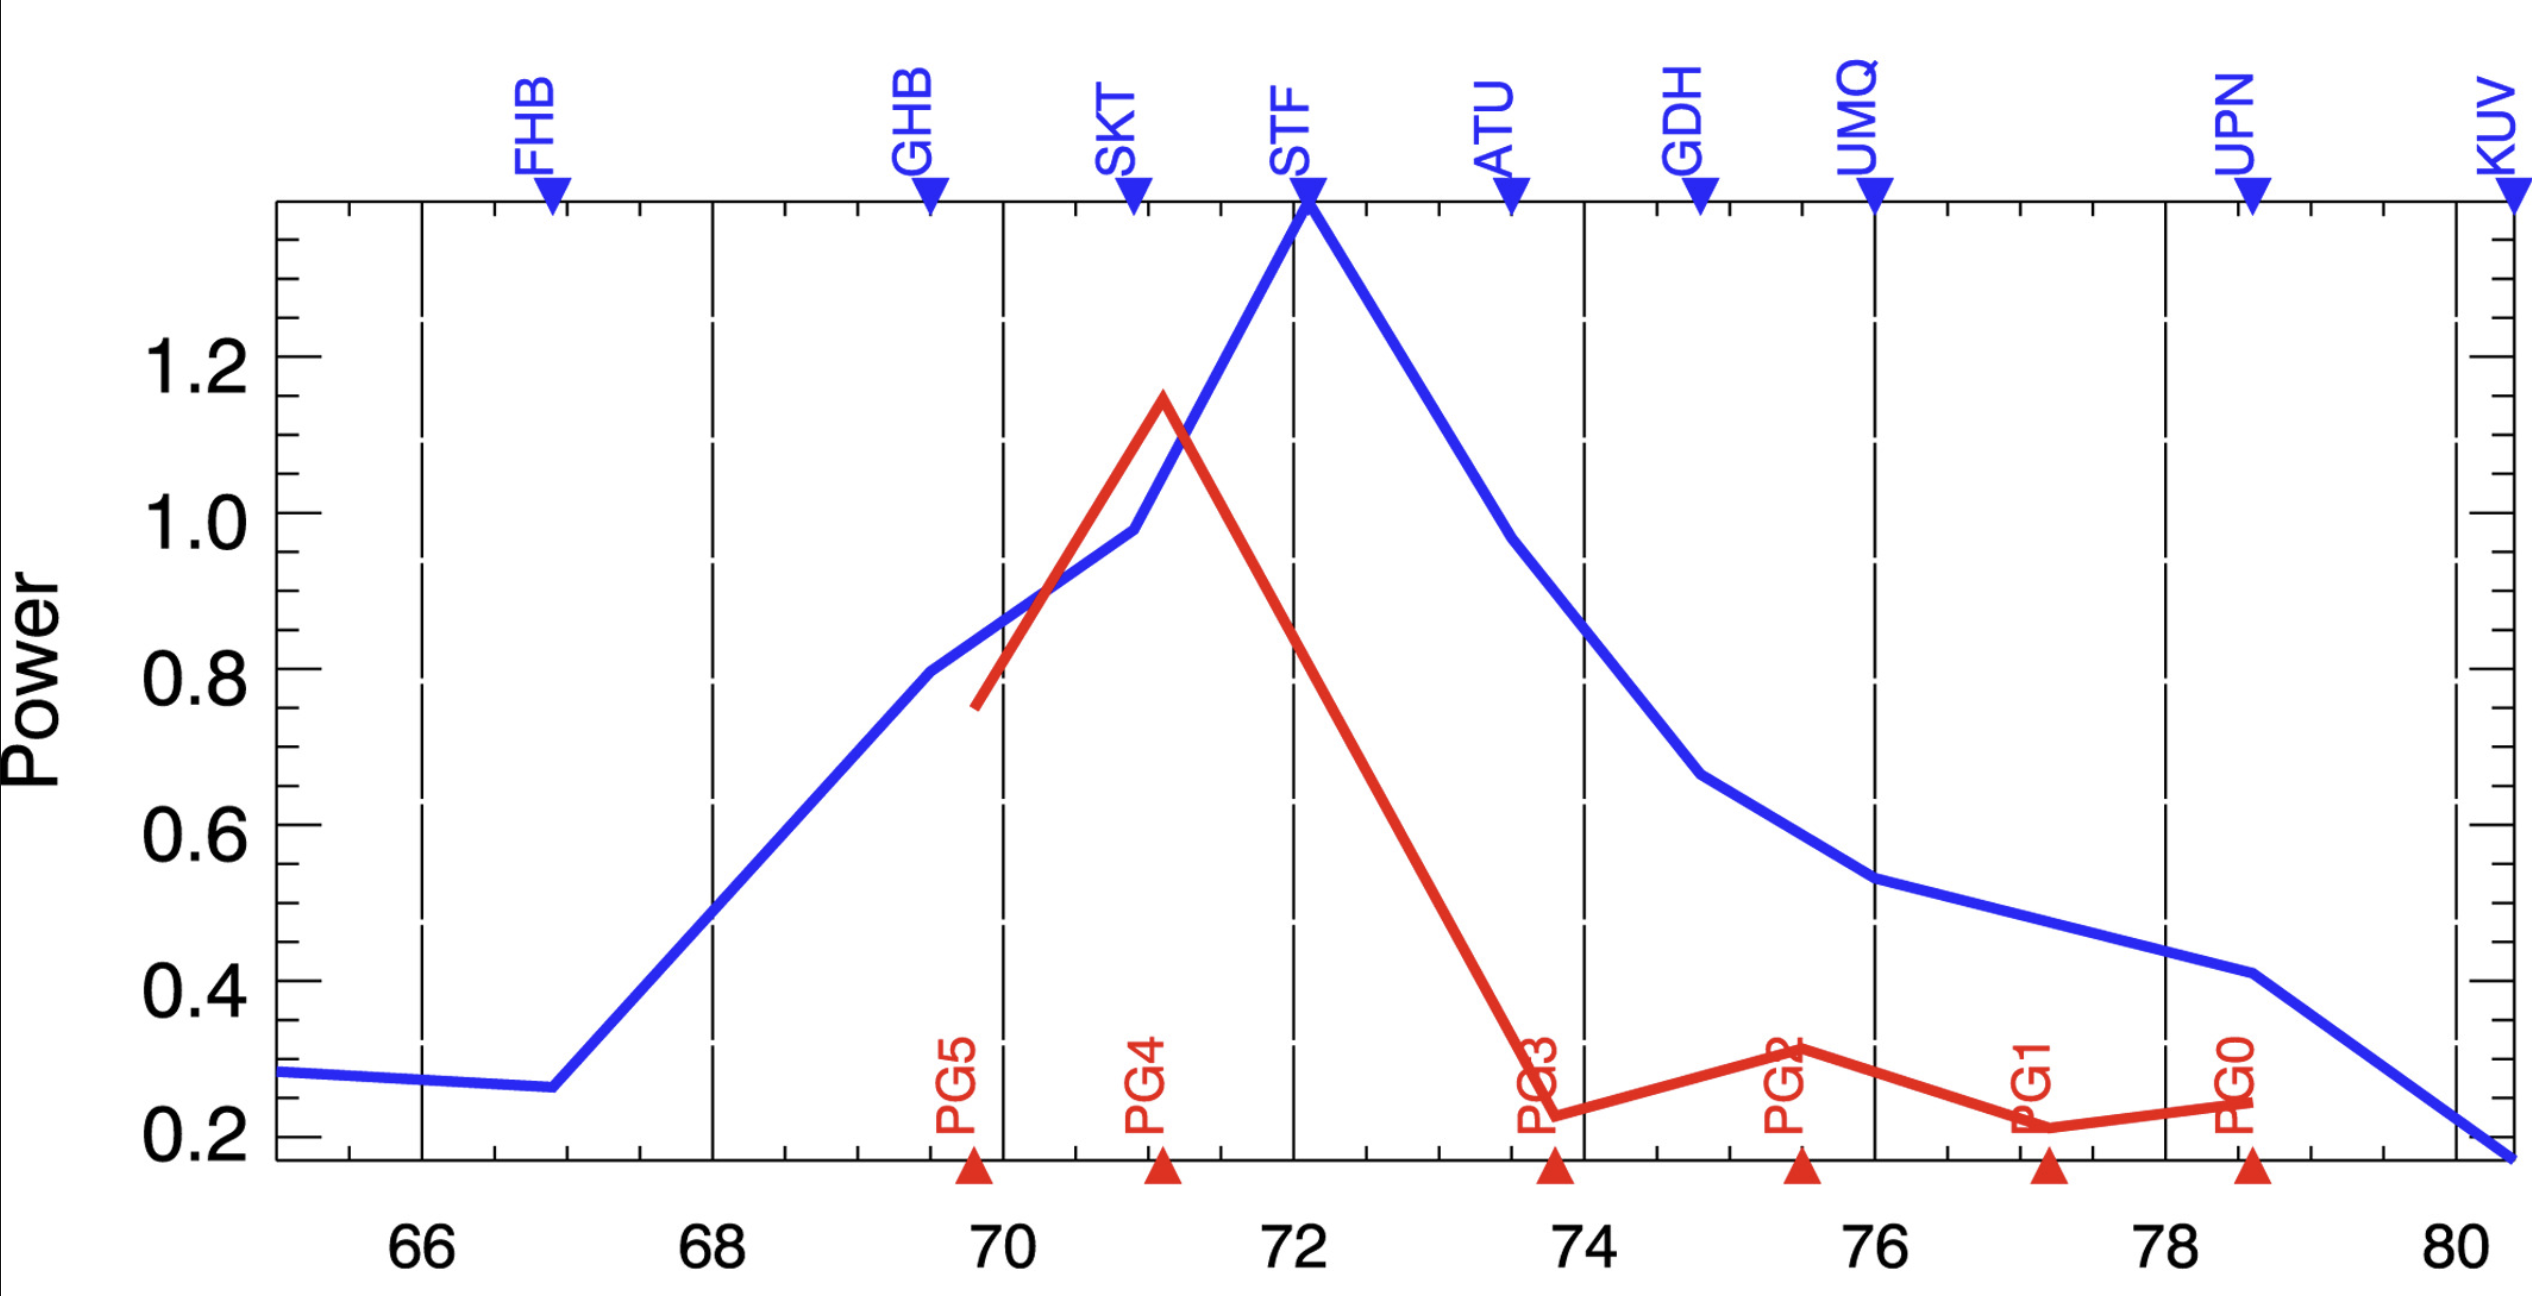

(Latitudinal profiles for the Northern (blue lines) and Southern (red lines) hemispheres during the time interval 08-13 UT, January 25, 2016: the spectral amplitude density [in nT/Hz1/2] in the frequency band 2.5–3.0 mHz of the Bx component. Conductances were estimated with the use of the OP model. The position of stations in magnetic latitude is marked by filled triangles.)


In [15]:
# Importing packages
import pandas as pd
smag = __import__('supermag-api')          # SuperMAG python API
logon = 'kd8oxt'                              # SuperMAG ID

import plotly.express as px                # for mapping, mainly
import plotly.graph_objects as go          # for mapping, mainly

import matplotlib.pyplot as plt
import numpy as np

# import os
# # os.environ["CDF_LIB"] = library_directory
# # os.environ["CDF_LIB"] = "~/CDF/lib"          # default "~/CDF/lib"
# from spacepy import pycdf                  # for reading CDF files

# For pulling data from CDAweb:
from ai import cdas
import datetime
from matplotlib import pyplot as plt

# for progress viz:
from tqdm .auto import tqdm
# from tqdm import tqdm_notebook as tqdm
# from tqdm.notebook import trange, tqdm
from IPython.display import clear_output     # Used as a workaround to make tqdm not do silly things

import pickle

from scipy import signal
from scipy.fft import fft

In [10]:
# Function to reject outliers. We'll need this to eliminate power cycling artifacts in the magnetometer plots.
def reject_outliers(y):   # y is the data in a 1D numpy array
    mean = np.mean(y)
    sd = np.std(y)
    final_list = np.copy(y)
    for n in range(len(y)):
        final_list[n] = y[n] if y[n] > mean - 3 * sd else np.nan
        final_list[n] = final_list[n] if final_list[n] < mean + 5 * sd else np.nan
    return final_list

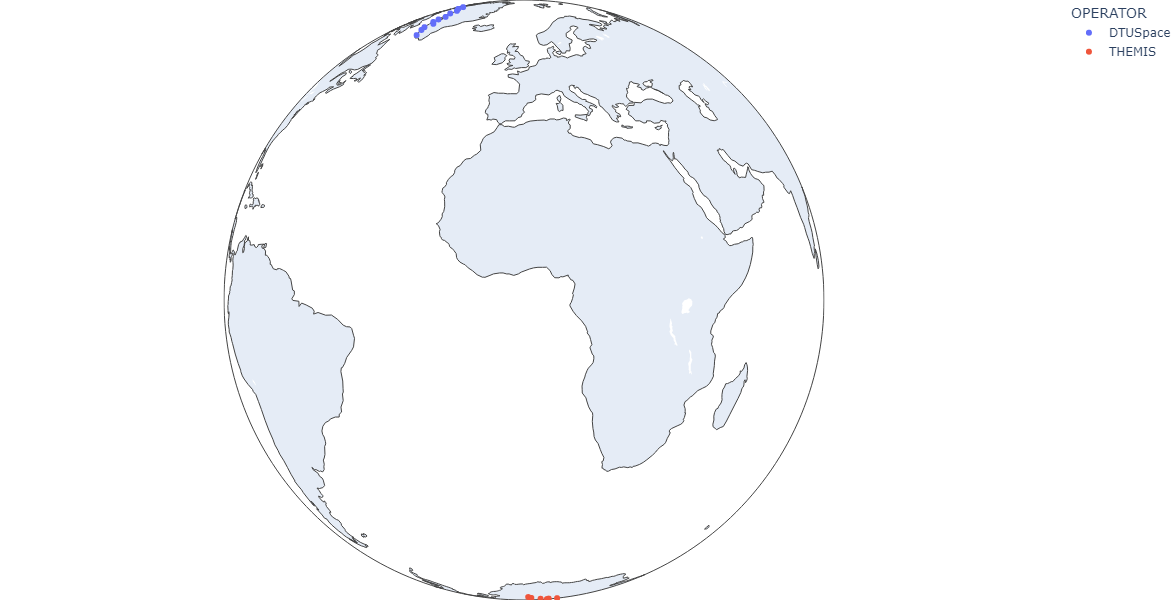

In [11]:
# Fetch station info from .csv and plot on a nice spinnable globe.
conjugate_stations = pd.read_csv('conjugate_stations.csv') # TODO: FIX THIS FILE!
conjugate_stations.Code

stations = pd.read_csv('20220726-04-17-supermag-stations.csv', sep = ',')   # edited version of this spreadsheet
stations = stations[stations.IAGA.isin(conjugate_stations.Code)] # Plot only the polar stations

# Plot stations:

fig = px.scatter_geo(stations, 
                     lat = stations.GEOLAT,
                     lon = stations.GEOLON,
                     color="OPERATOR", # size of markers, "pop" is one of the columns of gapminder
                     hover_name = "STATION-NAME", 
                     # text = "IAGA"
                     )
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#TODO: Overplot 40 deg magnetic meridian .... maybe I can pull this from geopack?


## FFT Approach

100% [..........................................................................] 1713919 / 1713919


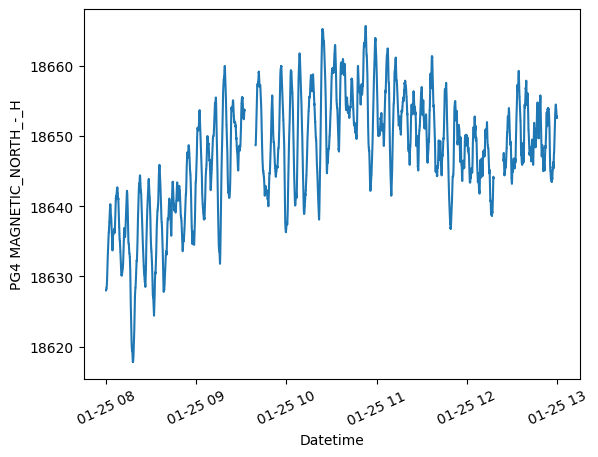

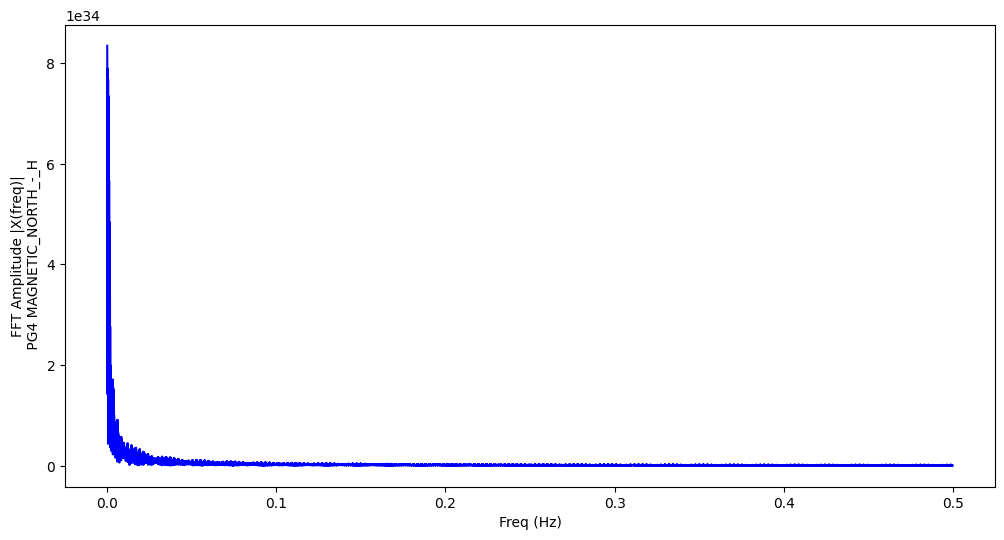

/tmp/ipykernel_343/3627657175.py:59: RuntimeWarning:

divide by zero encountered in divide



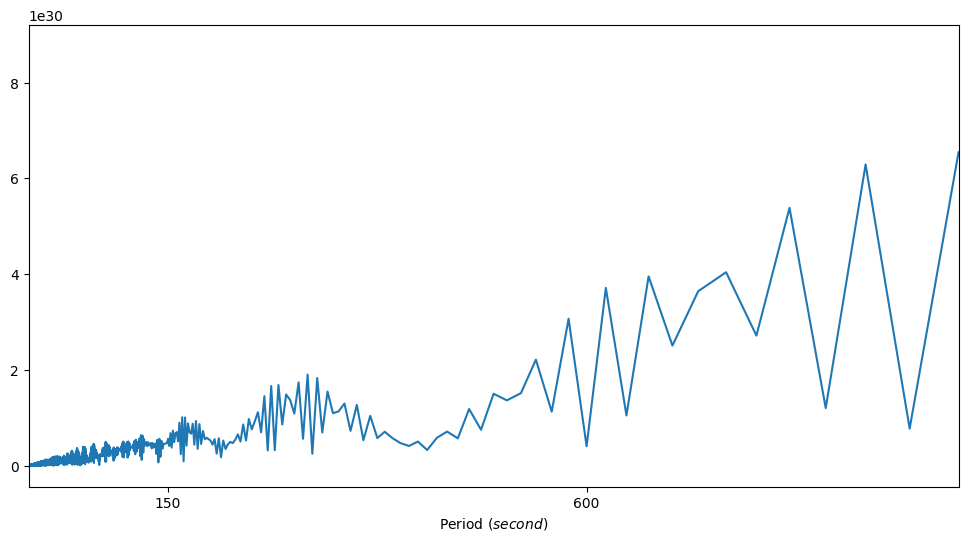

0.0275

In [12]:
magname = 'pg4'

parameter = 'MAGNETIC_NORTH_-_H'#'VERTICAL_DOWN_-_Z'
start = datetime.datetime(2016, 1, 25, 8, 0, 0) 
end = datetime.datetime(2016, 1, 25, 13, 0, 0)

# # print('Plotting data for Antarctic magnetometer #' + str(idx+1) + ': ' + magname.upper())
data = cdas.get_data(
    'sp_phys',
    'THG_L2_MAG_'+ magname.upper(),
    start,
    end,
    ['thg_mag_'+ magname]
)
# data['UT'] = pd.to_datetime(data['UT'])#, unit='s')
x =data['UT']
y =data[parameter]


y = reject_outliers(y) # Remove power cycling artifacts on, e.g., PG2.
# fy = np.fft.fft(y)
# fy = fft(y)

plt.plot(x, y)
# plt.plot(fy)
# plt.xlim([.001, .01])
plt.xlabel('Datetime')
plt.ylabel(magname.upper() + ' ' + parameter)
plt.xticks(rotation=25) 
plt.show()

########################################## Take Fourier xfrm:

X = fft(data[parameter])
N = len(X)                                  # N: Length of data vector
n = np.arange(N)                            
# get the sampling rate
sr = 1# / (60*60)
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

plt.figure(figsize = (12, 6))
plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|\n ' + magname.upper() + ' ' + parameter)
plt.show()

# # convert frequency to hour
# t_h = 1/f_oneside / (60 * 60)

# convert to seconds:
t_s = 1/f_oneside

plt.figure(figsize=(12,6))
plt.plot(t_s, np.abs(X[:n_oneside])/n_oneside)
# plt.xticks([12, 24, 84, 168])
plt.xticks([150, 600])
plt.xlim(0, 1000)
plt.xlabel('Period ($second$)')
plt.show()

############################### Integrate:
# sum(f_oneside[((f_oneside>=1.66=/1000) & (f_oneside<=6.66/1000))])
sum(f_oneside[((f_oneside>=2.5/1000) & (f_oneside<=3/1000))])

In [37]:
# FFT-driven wavepwr() function:

# Define a function to calculate wave power, given a station ID, time range and frequency range of interest:
def wavepwr(station_id):#tart, end, freqs):
    magname = station_id.lower()#'stf'
    # print(magname)
    parameter = 'MAGNETIC_NORTH_-_H'#'VERTICAL_DOWN_-_Z'
    start = datetime.datetime(2016, 1, 25, 8, 0, 0) 
    end = datetime.datetime(2016, 1, 25, 13, 0, 0)
    try: 
        data = cdas.get_data(
            'sp_phys',
            'THG_L2_MAG_'+ magname.upper(),
            start,
            end,
            ['thg_mag_'+ magname]
        )
        # data['UT'] = pd.to_datetime(data['UT'])#, unit='s')
        x =data['UT']
        y =data[parameter]


        y = reject_outliers(y) # Remove power cycling artifacts on, e.g., PG2.
        # fy = np.fft.fft(y)
        # fy = fft(y)

#         plt.plot(x, y)
#         # plt.plot(fy)
#         # plt.xlim([.001, .01])
#         plt.xlabel('Datetime')
#         plt.ylabel(magname.upper() + ' ' + parameter)
#         plt.xticks(rotation=25) 
#         plt.show()

        ########################################## Take Fourier xfrm:

        X = fft(data[parameter])
        N = len(X)                                  # N: Length of data vector
        n = np.arange(N)                            
        # get the sampling rate
        sr = 1# / (60*60)
        T = N/sr
        freq = n/T 

        # Get the one-sided specturm
        n_oneside = N//2
        # get the one side frequency
        f_oneside = freq[:n_oneside]

        # plt.figure(figsize = (12, 6))
        # plt.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
        # plt.xlabel('Freq (Hz)')
        # plt.ylabel('FFT Amplitude |X(freq)|\n ' + magname.upper() + ' ' + parameter)
        # plt.show()

        # # convert frequency to hour
        # t_h = 1/f_oneside / (60 * 60)

        # plt.figure(figsize=(12,6))
        # plt.plot(t_h, np.abs(X[:n_oneside])/n_oneside)
        # plt.xticks([12, 24, 84, 168])
        # plt.xlim(0, 200)
        # plt.xlabel('Period ($hour$)')
        # plt.show()

        ############################### Integrate:
        foo = np.abs(X[:n_oneside])/n_oneside
        pwr = sum(foo[((f_oneside>=2/1000) & (f_oneside<=3/1000))])
        return pwr
    except:
        return 'Error'
    
wavepwr('pg4')

100% [..........................................................................] 1713919 / 1713919


1.4895282426674489e+31

## Welch's Method

100% [..........................................................................] 1713919 / 1713919
5001 5001


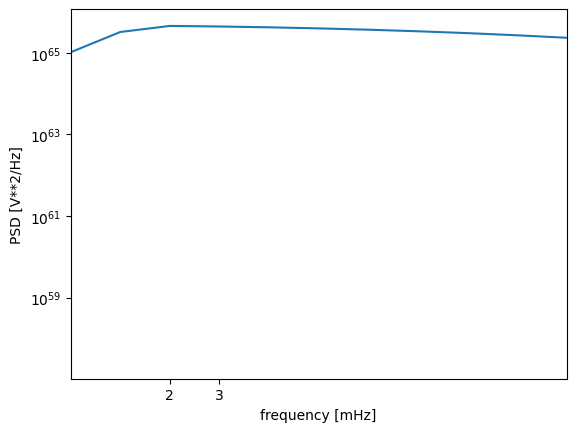

8.002773980397302e+63

In [38]:
# TESTING SCIPY WELCH W/ SIGNAL

magname = 'pg4'

parameter = 'MAGNETIC_NORTH_-_H'#'VERTICAL_DOWN_-_Z'
start = datetime.datetime(2016, 1, 25, 8, 0, 0) 
end = datetime.datetime(2016, 1, 25, 13, 0, 0)

data = cdas.get_data(
    'sp_phys',
    'THG_L2_MAG_'+ magname.upper(),
    start,
    end,
    ['thg_mag_'+ magname]
)
# data['UT'] = pd.to_datetime(data['UT'])#, unit='s')
x =data['UT']
y =data[parameter]
sr = 1 # sampling at 1 Hz

f, Pxx_den = signal.welch(y, sr, nperseg=10000)
print(len(f), len(Pxx_den))
plt.semilogy(f*10000, Pxx_den)
# plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [mHz]')
# plt.xticks([1.66, 6.66])
plt.xticks([2, 3])
plt.xlim([0, 10])
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Calculate noise power:
np.mean(Pxx_den[((f>=2/1000) & (f<=3/1000))])
# np.trapz(Pxx_den[((f>=2/1000) & (f<=3/1000))])


# Create plot:

100% [..............................................................................] 32766 / 32766
100% [..........................................................................] 1713936 / 1713936
100% [..............................................................................] 32760 / 32760
100% [..........................................................................] 1713919 / 1713919
100% [..............................................................................] 32805 / 32805
100% [..............................................................................] 32813 / 32813
100% [..........................................................................] 1713919 / 1713919
100% [..............................................................................] 31151 / 31151
100% [..........................................................................] 1713907 / 1713907
100% [..............................................................................] 32811 / 32811


,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,OPERATOR-NUM,OPERATOR,OP2,OP3,Unnamed: 10,Unnamed: 11,HEMISPHERE,ABSLAT,WAVEPWR
61,FHB,310.32,62.00,39.05,67.41,Paamiut,1,DTUSpace,NaN,NaN,NaN,NaN,Arctic,67.41,0.000000e+00
536,PG5,5.71,-81.96,37.17,-69.46,PG5,2,THEMIS,MIST,NaN,NaN,NaN,Antarctic,69.46,1.347732e+01
60,GHB,308.27,64.17,37.85,69.98,Nuuk,1,DTUSpace,NaN,NaN,NaN,NaN,Arctic,69.98,0.000000e+00
443,PG4,12.25,-83.34,36.39,-70.83,Antartica,2,THEMIS,MIST,NaN,NaN,NaN,Antarctic,70.83,1.489528e+31
59,SKT,307.10,65.42,37.22,71.43,Maniitsoq,1,DTUSpace,NaN,NaN,NaN,NaN,Arctic,71.43,0.000000e+00
58,STF,309.28,67.02,40.87,72.64,Kangerlussuaq,1,DTUSpace,NaN,NaN,NaN,NaN,Arctic,72.64,0.000000e+00
442,PG3,37.63,-84.81,36.76,-73.53,Antartica,2,THEMIS,MIST,NaN,NaN,NaN,Antarctic,73.53,1.829804e+01
57,ATU,306.43,67.93,38.19,73.99,Attu,1,DTUSpace,NaN,NaN,NaN,NaN,Arctic,73.99,0.000000e+00
441,PG2,57.96,-84.42,39.07,-75.24,Antartica,2,THEMIS,MIST,NaN,NaN,NaN,Antarctic,75.24,1.647414e+31
56,GDH,306.47,69.25,39.39,75.25,Godhavn,2,DTUSpace,INTERMAGNET,NaN,NaN,NaN,Arctic,75.25,0.000000e+00


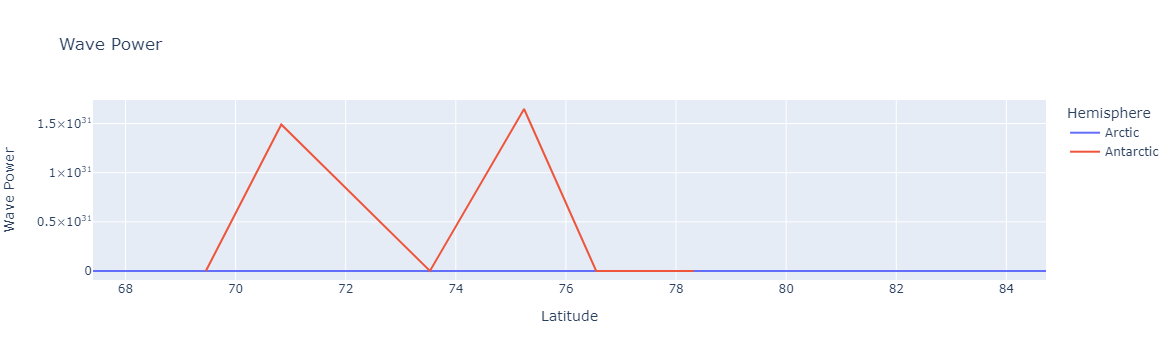

In [36]:
# Starting code to create wave power figure... plug in a functional version of wavepwr().

foo = stations.copy()
foo['HEMISPHERE'] = np.sign(foo.AACGMLAT)
foo.HEMISPHERE = foo['HEMISPHERE'].map({1:'Arctic', -1:'Antarctic', 0:'Error'})
foo['ABSLAT'] = abs(foo.AACGMLAT)
foo = foo.sort_values('ABSLAT')
foo['WAVEPWR'] = foo.apply(lambda row : wavepwr(row['IAGA']), axis = 1)#wavepwr(foo['IAGA'])
px.scatter(foo.WAVEPWR, abs(foo.AACGMLAT))
df = px.data.iris()
fig = px.line(foo, x='ABSLAT', y="WAVEPWR", color='HEMISPHERE', hover_data=['IAGA'],
                labels={
                     'ABSLAT': "Latitude",
                     "WAVEPWR": "Wave Power",
                     "AACGMLAT": "Latitude",
                     "HEMISPHERE": "Hemisphere"
                 },
                title="Wave Power")
fig.update_layout({
    # 'plot_bgcolor': 'rgba(0, 0, 0, 0)',    # ditch gray background
    # 'paper_bgcolor': 'rgba(0, 0, 0, 0)',   # transparent figure
})

fig.update_traces(connectgaps=True)

display(foo)
fig.show()

Again, for comparison: 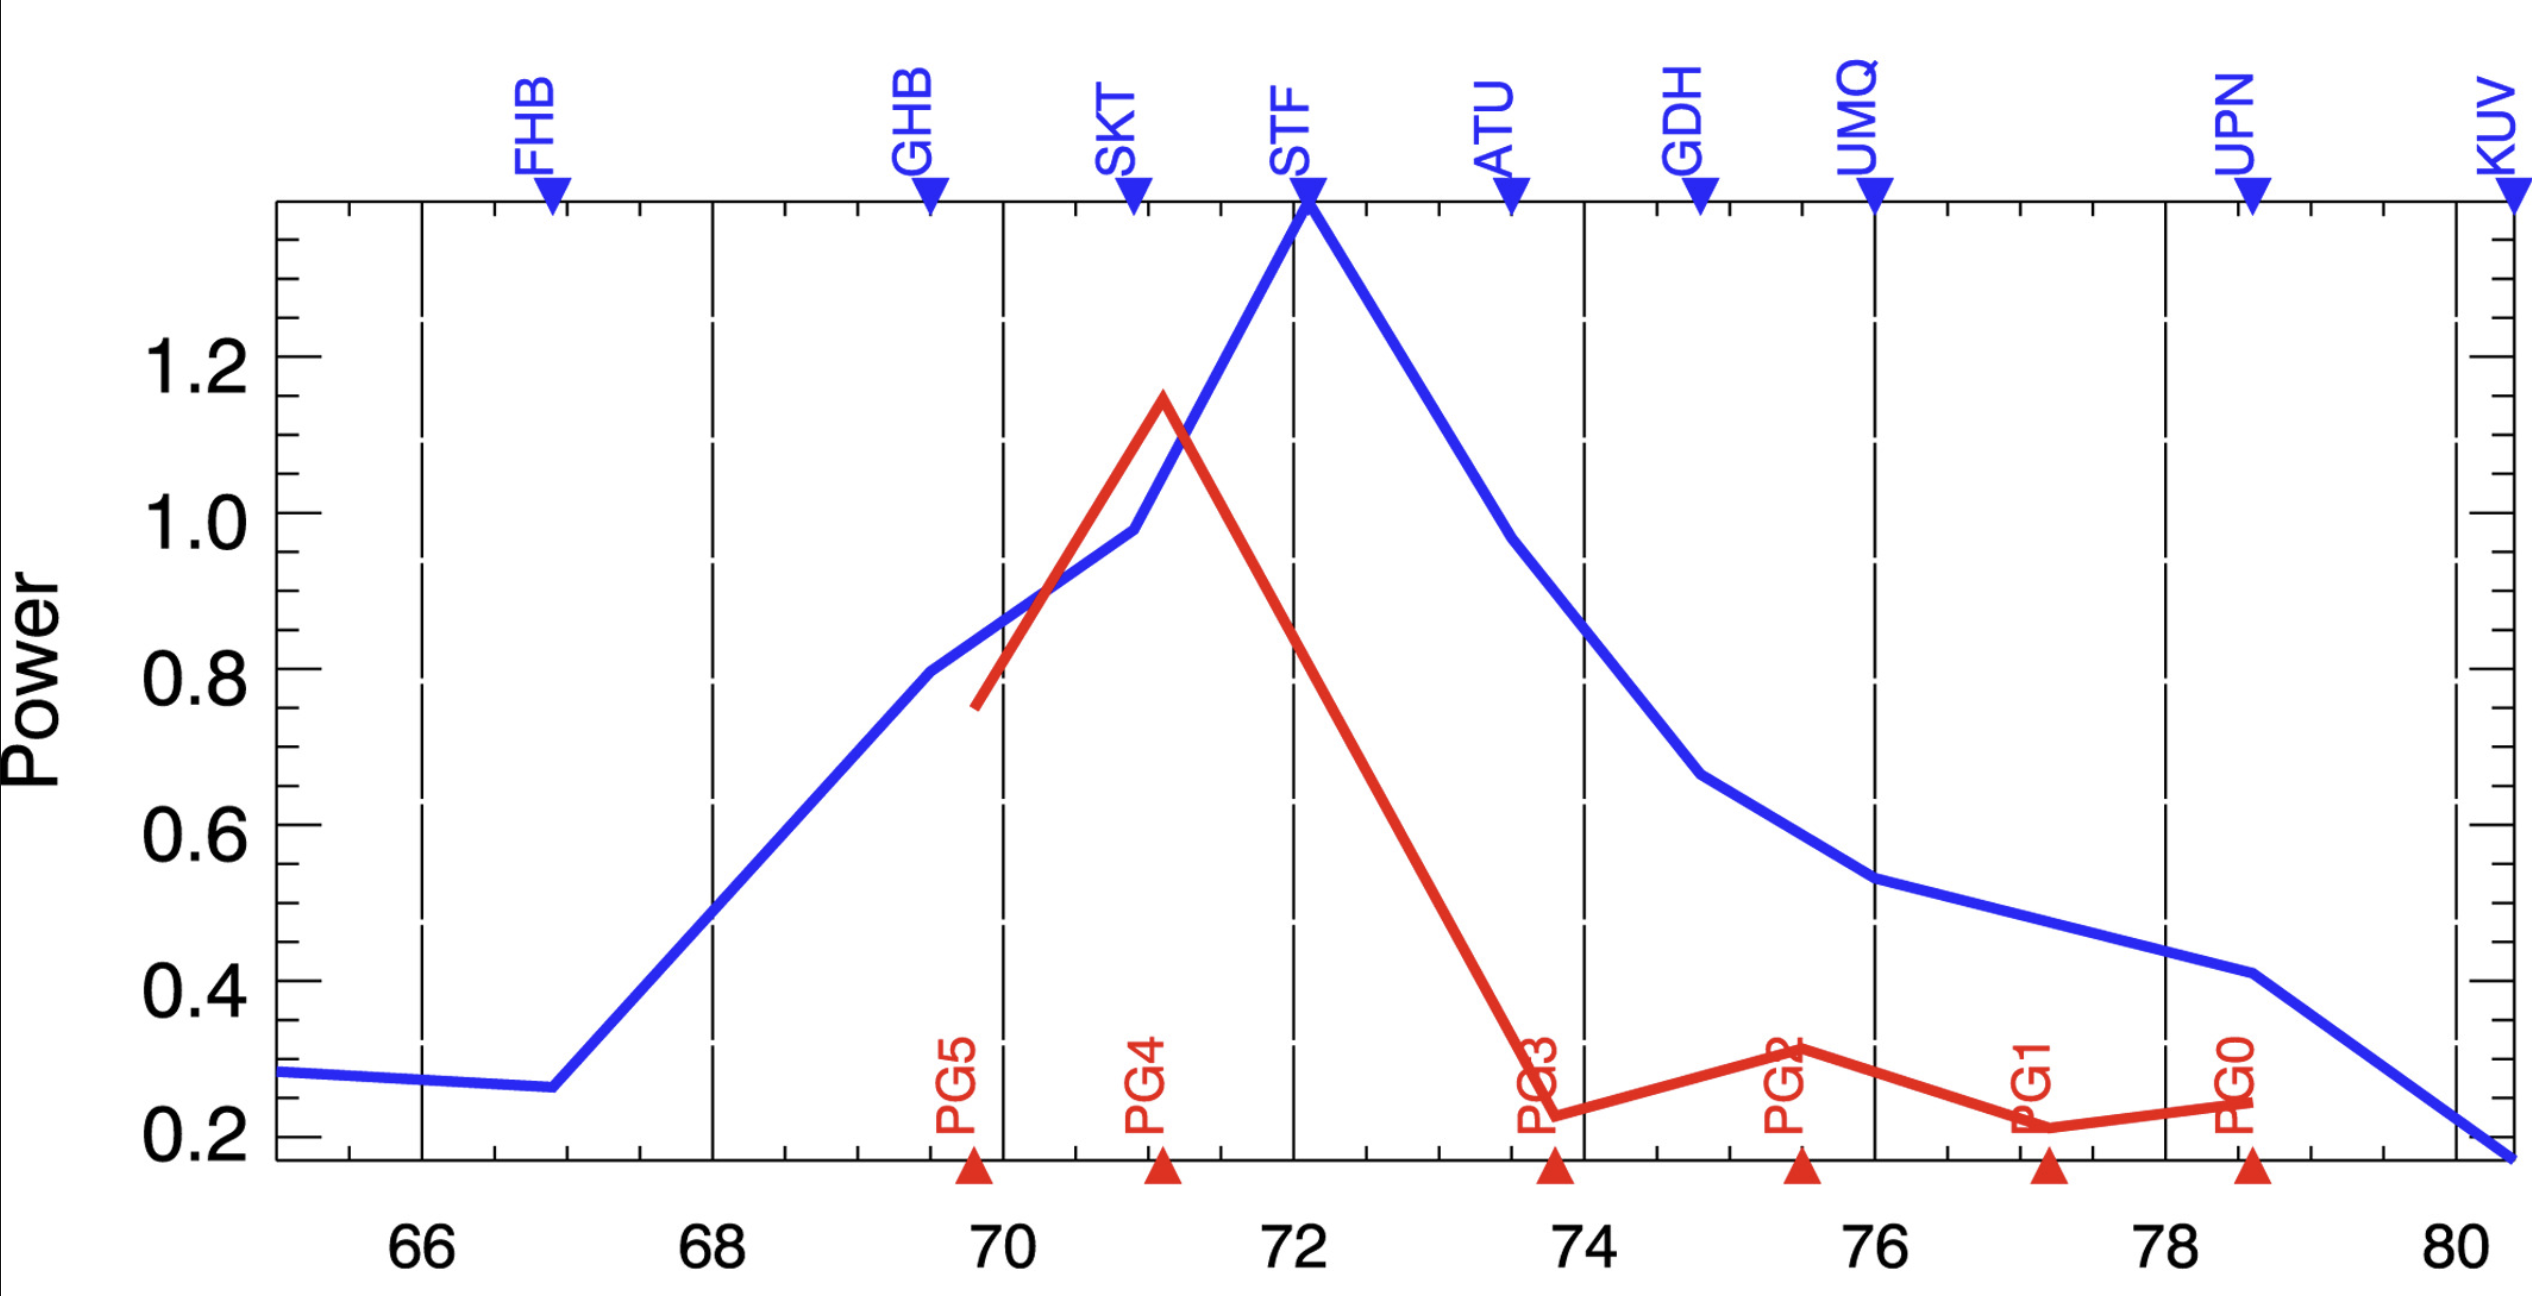